Script to generate everything but the heat budget terms and schematic arrows (added in photoshop) in Fig 10:
- Temperature response of the Ross Sea continental shelf region. (a-c) Time-mean advective (red
arrows, TW) and surface (red circles, TW) heat flux in and out of the Ross Sea region under control (a), MW45
(b), and MW85 (c) meltwater forcing. Note that 0C referenced heat fluxes do not necessarily align with the
direction of flow; where volume and heat fluxes point in opposite directions, this may be interpreted as a net flow
of water with average temperature less than 0C. ?Net? values indicate the rate of volume averaged heat gain in
the region over the 10 year perturbed simulations. Shading shows depth mean temperature (a) and temperature
anomalies (b, c) averaged over the final year of the experimental period. (d-i) Temperature (q, shading) and
potential density (s1, contours) along transects crossing the Joides Trough in the western Ross Sea (d-f) and the
Little America Basin in the eastern Ross Sea (g-i), averaged over the final year of the experimental period for the
three simulations. Transect locations are delineated by numbered lines in (a). Stippling in (e, h, f, l) highlights
positive salinity anomalies.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col
import matplotlib.path as mpath
### establish link to python functions
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from gsw import SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from dask.distributed import Client
client = Client('tcp://localhost:8786')
import cmocean.cm as cmo
from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':22})
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'
rcp45='01deg_jra55v13_ryf8485_freshRCP45'
rcp85='01deg_jra55v13_ryf8485_freshRCP85'

In [3]:
rc('text', usetex=True)
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20) 

In [4]:
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-59))
land_mask = (ht*0).fillna(1)
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

In [5]:
filename = '../Honours_Thesis/Maps/rcp45_depthmean_temp_end.nc'
rcp45_depthmean_temp = xr.open_dataset(filename)
rcp45_depthmean_temp = rcp45_depthmean_temp.temp
filename = '../Honours_Thesis/Maps/rcp85_depthmean_temp_end.nc'
rcp85_depthmean_temp = xr.open_dataset(filename)
rcp85_depthmean_temp = rcp85_depthmean_temp.temp
filename = '../Honours_Thesis/Maps/control_depthmean_temp_end.nc'
control_depthmean_temp = xr.open_dataset(filename)
control_depthmean_temp = control_depthmean_temp.temp

In [6]:
rcp45_depthmean_temp = rcp45_depthmean_temp - 273.15
rcp85_depthmean_temp = rcp85_depthmean_temp - 273.15
control_depthmean_temp = control_depthmean_temp - 273.15
rcp45_depthmean_temp_anomaly = rcp45_depthmean_temp - control_depthmean_temp
rcp85_depthmean_temp_anomaly = rcp85_depthmean_temp - control_depthmean_temp

In [7]:
blank = shelf_mask * 0 + 1
ross_mask = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -60).where(blank.xt_ocean > -198).where(blank.xt_ocean < -157)
ross_map = ross_mask.fillna(0)

In [8]:
rcp45_ross_temp_anomaly = rcp45_depthmean_temp_anomaly * ross_mask
rcp85_ross_temp_anomaly = rcp85_depthmean_temp_anomaly * ross_mask
control_ross_temp = control_depthmean_temp * ross_mask
rcp45_ross_temp_anomaly, shelf_map = shelf_mask_isobath(rcp45_ross_temp_anomaly)
rcp85_ross_temp_anomaly, shelf_map = shelf_mask_isobath(rcp85_ross_temp_anomaly)
control_ross_temp, shelf_map = shelf_mask_isobath(control_ross_temp)
control_depthmean_temp_shelf, shelf_map = shelf_mask_isobath(control_depthmean_temp)
rcp45_depthmean_temp_anomaly, shelf_map = shelf_mask_isobath(rcp45_depthmean_temp_anomaly)
rcp85_depthmean_temp_anomaly, shelf_map = shelf_mask_isobath(rcp85_depthmean_temp_anomaly)

In [9]:
def ross_temp_maps(ax,ax2,ax3):
    norm1 = col.Normalize(vmin=-2,vmax=2)    
    control_temp = ax.pcolormesh(control_depthmean_temp_shelf.xt_ocean,control_depthmean_temp_shelf.yt_ocean,control_depthmean_temp_shelf.values,cmap='RdBu_r',norm=norm1)
    ax.contour(land_mask.xt_ocean, land_mask.yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
    ax.contour(ht_shelf.xt_ocean, ht_shelf.yt_ocean, shelf_mask.values, [0,1], colors = 'k', linewidth = 6)
    ax.set_xlim((-198,-157))
    ax.set_ylim((-79,-67))
    anomaly_temp = ax2.pcolormesh(rcp45_depthmean_temp_anomaly.xt_ocean,rcp45_depthmean_temp_anomaly.yt_ocean,rcp45_depthmean_temp_anomaly.values,cmap='seismic',norm=norm1)
    ax2.contour(land_mask.xt_ocean, land_mask.yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
    ax2.contour(ht_shelf.xt_ocean, ht_shelf.yt_ocean, shelf_mask.values, [0,1], colors = 'k', linewidth = 6)
    ax2.set_xlim((-198,-157))
    ax2.set_ylim((-79,-67))
    ax3.pcolormesh(rcp85_depthmean_temp_anomaly.xt_ocean,rcp85_depthmean_temp_anomaly.yt_ocean,rcp85_depthmean_temp_anomaly.values,cmap='seismic',norm=norm1)
    ax3.contour(land_mask.xt_ocean, land_mask.yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
    ax3.contour(ht_shelf.xt_ocean, ht_shelf.yt_ocean, shelf_mask.values, [0,1], colors = 'k', linewidth = 6)
    ax3.set_xlim((-198,-157))
    ax3.set_ylim((-79,-67))
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    return control_temp, anomaly_temp

In [10]:
# need salt and temp for salinity anomaly and sigma1
temp_control = cc.querying.getvar(control, 'temp',session, 'ocean.nc',n = -63)
salt_control = cc.querying.getvar(control, 'salt',session, 'ocean.nc',n = -63)
temp_rcp45 = cc.querying.getvar(rcp45, 'temp',session, 'ocean.nc',n = -120)
salt_rcp45 = cc.querying.getvar(rcp45, 'salt',session, 'ocean.nc',n = -120)
temp_rcp85 = cc.querying.getvar(rcp85, 'temp',session, 'ocean.nc',n = None)
salt_rcp85 = cc.querying.getvar(rcp85, 'salt',session, 'ocean.nc',n = None)
## will only consider the time mean of the final year
temp_control = temp_control.sel(time = slice('1946-06','1947-05')).sel(yt_ocean = slice(-90,-60))
salt_control = salt_control.sel(time = slice('1946-06','1947-05')).sel(yt_ocean = slice(-90,-60))
temp_rcp45 = temp_rcp45.sel(time = slice('1946-06','1947-05')).sel(yt_ocean = slice(-90,-60))
salt_rcp45 = salt_rcp45.sel(time = slice('1946-06','1947-05')).sel(yt_ocean = slice(-90,-60))
temp_rcp45 = temp_rcp45.isel(time = slice(0,12))
salt_rcp45 = salt_rcp45.isel(time = slice(0,12))
temp_rcp85 = temp_rcp85.sel(time = slice('1946-06','1947-05')).sel(yt_ocean = slice(-90,-60))
salt_rcp85 = salt_rcp85.sel(time = slice('1946-06','1947-05')).sel(yt_ocean = slice(-90,-60))

In [11]:
### control
time = temp_control.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})
temp_control = (temp_control * weights).mean(dim = 'time')
salt_control = (salt_control * weights).mean(dim = 'time')
### rcp45
time = temp_rcp45.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})
temp_rcp45 = (temp_rcp45 * weights).mean(dim = 'time')
salt_rcp45 = (salt_rcp45 * weights).mean(dim = 'time')
### rcp85
time = temp_rcp85.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})
temp_rcp85 = (temp_rcp85 * weights).mean(dim = 'time')
salt_rcp85 = (salt_rcp85 * weights).mean(dim = 'time')

In [12]:
### joides trough transect
lons = [-193, -181]
lats = [-78, -72]
yt_ocean = temp_control.yt_ocean
lat_array = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]
lon_array_perf = slope * lat_array + intercept

lon_array_perf = xr.DataArray(lon_array_perf, dims = 'yt_ocean')
lat_array = xr.DataArray(lat_array, dims = 'yt_ocean') ## vectorised indexing 

temp_transect_rcp45 = temp_rcp45.sel(xt_ocean = lon_array_perf, yt_ocean = lat_array, method = 'nearest')
temp_transect_rcp45 = temp_transect_rcp45.load()- 273.15
temp_transect_rcp85 = temp_rcp85.sel(xt_ocean = lon_array_perf, yt_ocean = lat_array, method = 'nearest')
temp_transect_rcp85 = temp_transect_rcp85.load()- 273.15
temp_transect_control = temp_control.sel(xt_ocean = lon_array_perf, yt_ocean = lat_array, method = 'nearest')
temp_transect_control = temp_transect_control.load() -273.15
salt_transect_control = salt_control.sel(xt_ocean = lon_array_perf, yt_ocean = lat_array, method = 'nearest')
salt_transect_control = salt_transect_control.load()
salt_transect_rcp45 = salt_rcp45.sel(xt_ocean = lon_array_perf, yt_ocean = lat_array, method = 'nearest')
salt_transect_rcp45 = salt_transect_rcp45.load()
salt_transect_rcp85 = salt_rcp85.sel(xt_ocean = lon_array_perf, yt_ocean = lat_array, method = 'nearest')
salt_transect_rcp85 = salt_transect_rcp85.load()
## sigma1_contours
st_ocean = temp_transect_rcp45.st_ocean
depth = -st_ocean
depth = xr.DataArray(depth, coords = [st_ocean], dims = ['st_ocean'])
yt_transect = temp_transect_rcp45.yt_ocean
xt_transect = temp_transect_rcp45.xt_ocean
depth_transect = (temp_transect_rcp45*0+1) * depth
pressure_transect = xr.DataArray(p_from_z(depth_transect.values,yt_transect), coords = [st_ocean, yt_transect], dims = ['st_ocean','yt_ocean'],  name = 'pressure', attrs = {'units':'dbar'})
##
transect_PSU = salt_transect_rcp45
transect_PT = temp_transect_rcp45
AS_rcp45= xr.DataArray(SA_from_SP(transect_PSU.values,pressure_transect,xt_transect,yt_transect), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
CT_rcp45 = xr.DataArray(CT_from_pt(AS_rcp45,transect_PT.values), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
sigma1_rcp45 = xr.DataArray(sigma1(AS_rcp45, CT_rcp45),coords = [st_ocean, yt_transect], dims = ['st_ocean', 'yt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
##
transect_PSU = salt_transect_rcp85
transect_PT = temp_transect_rcp85
AS_rcp85= xr.DataArray(SA_from_SP(transect_PSU.values,pressure_transect,xt_transect,yt_transect), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
CT_rcp85 = xr.DataArray(CT_from_pt(AS_rcp85,transect_PT.values), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
sigma1_rcp85 = xr.DataArray(sigma1(AS_rcp85, CT_rcp85),coords = [st_ocean, yt_transect], dims = ['st_ocean', 'yt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
##
transect_PSU = salt_transect_control
transect_PT = temp_transect_control
AS_control= xr.DataArray(SA_from_SP(transect_PSU.values,pressure_transect,xt_transect,yt_transect), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
CT_control = xr.DataArray(CT_from_pt(AS_control,transect_PT.values), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
sigma1_control = xr.DataArray(sigma1(AS_control, CT_control),coords = [st_ocean, yt_transect], dims = ['st_ocean', 'yt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})

In [13]:
AS_rcp45_west_ross = AS_rcp45
CT_rcp45_west_ross = CT_rcp45
sigma1_rcp45_west_ross = sigma1_rcp45
AS_rcp85_west_ross = AS_rcp85
CT_rcp85_west_ross = CT_rcp85
sigma1_rcp85_west_ross = sigma1_rcp85
AS_control_west_ross = AS_control
CT_control_west_ross = CT_control
sigma1_control_west_ross = sigma1_control
xt_transect_west_ross = xt_transect
yt_transect_west_ross = yt_transect

In [14]:
## east ross transect
yt_ocean = temp_control.yt_ocean
temp_transect_rcp45 = temp_rcp45.sel(xt_ocean = -163, method = 'nearest') - 273.15
temp_transect_rcp85 = temp_rcp85.sel(xt_ocean = -163, method = 'nearest') - 273.15
temp_transect_control = temp_control.sel(xt_ocean = -163, method = 'nearest') - 273.15
salt_transect_rcp45 = salt_rcp45.sel(xt_ocean = -163, method = 'nearest') 
salt_transect_rcp85 = salt_rcp85.sel(xt_ocean = -163, method = 'nearest') 
salt_transect_control = salt_control.sel(xt_ocean = -163, method = 'nearest') 
st_ocean = temp_transect_rcp45.st_ocean
depth = -st_ocean
depth = xr.DataArray(depth, coords = [st_ocean], dims = ['st_ocean'])
yt_transect = temp_transect_rcp45.yt_ocean
xt_transect = temp_transect_rcp45.xt_ocean
depth_transect = (temp_transect_rcp45*0+1) * depth
pressure_transect = xr.DataArray(p_from_z(depth_transect.values,yt_transect), coords = [st_ocean, yt_transect], dims = ['st_ocean','yt_ocean'],  name = 'pressure', attrs = {'units':'dbar'})
##
transect_PSU = salt_transect_rcp45
transect_PT = temp_transect_rcp45
AS_rcp45= xr.DataArray(SA_from_SP(transect_PSU.values,pressure_transect,xt_transect,yt_transect), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
CT_rcp45 = xr.DataArray(CT_from_pt(AS_rcp45,transect_PT.values), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
sigma1_rcp45 = xr.DataArray(sigma1(AS_rcp45, CT_rcp45),coords = [st_ocean, yt_transect], dims = ['st_ocean', 'yt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
##
transect_PSU = salt_transect_rcp85
transect_PT = temp_transect_rcp85
AS_rcp85= xr.DataArray(SA_from_SP(transect_PSU.values,pressure_transect,xt_transect,yt_transect), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
CT_rcp85 = xr.DataArray(CT_from_pt(AS_rcp85,transect_PT.values), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
sigma1_rcp85 = xr.DataArray(sigma1(AS_rcp85, CT_rcp45),coords = [st_ocean, yt_transect], dims = ['st_ocean', 'yt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
##
transect_PSU = salt_transect_control
transect_PT = temp_transect_control
AS_control= xr.DataArray(SA_from_SP(transect_PSU.values,pressure_transect,xt_transect,yt_transect), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
CT_control = xr.DataArray(CT_from_pt(AS_control,transect_PT.values), coords = [st_ocean,yt_transect], dims = ['st_ocean','yt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
sigma1_control = xr.DataArray(sigma1(AS_control, CT_control),coords = [st_ocean, yt_transect], dims = ['st_ocean', 'yt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})

In [15]:
AS_rcp45_east_ross = AS_rcp45
CT_rcp45_east_ross = CT_rcp45
sigma1_rcp45_east_ross = sigma1_rcp45
AS_rcp85_east_ross = AS_rcp85
CT_rcp85_east_ross = CT_rcp85
sigma1_rcp85_east_ross = sigma1_rcp85
AS_control_east_ross = AS_control
CT_control_east_ross = CT_control
sigma1_control_east_ross = sigma1_control
xt_transect_east_ross = xt_transect
yt_transect_east_ross = yt_transect

In [16]:
AS_rcp45_east_ross_anom = AS_rcp45_east_ross - AS_control_east_ross
AS_rcp85_east_ross_anom = AS_rcp85_east_ross - AS_control_east_ross
AS_rcp45_west_ross_anom = AS_rcp45_west_ross - AS_control_west_ross
AS_rcp85_west_ross_anom = AS_rcp85_west_ross - AS_control_west_ross

In [17]:
AS_rcp45_er_mask = AS_rcp45_east_ross_anom.where(AS_rcp45_east_ross_anom>0) *0
AS_rcp45_er_mask = AS_rcp45_er_mask.fillna(1)
AS_rcp85_er_mask = AS_rcp85_east_ross_anom.where(AS_rcp85_east_ross_anom>0) *0
AS_rcp85_er_mask = AS_rcp85_er_mask.fillna(1)
AS_rcp45_wr_mask = AS_rcp45_west_ross_anom.where(AS_rcp45_west_ross_anom>0) *0
AS_rcp45_wr_mask = AS_rcp45_wr_mask.fillna(1)
AS_rcp85_wr_mask = AS_rcp85_west_ross_anom.where(AS_rcp85_west_ross_anom>0) *0
AS_rcp85_wr_mask = AS_rcp85_wr_mask.fillna(1)

In [26]:
def east_ross_transects(ax,ax2,ax3):
    levels = np.arange(-2.5,2.5,0.01)
    norm = col.Normalize(vmin=-2.5,vmax=2.5) 

    temp = ax2.contourf(CT_rcp45_east_ross.yt_ocean,CT_rcp45_east_ross.st_ocean,CT_rcp45_east_ross.values,levels=levels,cmap='RdBu_r',norm=norm ,extend='both')
    ax3.contourf(CT_rcp85_east_ross.yt_ocean,CT_rcp85_east_ross.st_ocean,CT_rcp85_east_ross.values,levels=levels,cmap='RdBu_r',norm=norm ,extend='both')
    ax.contourf(CT_control_east_ross.yt_ocean,CT_control_east_ross.st_ocean,CT_control_east_ross.values,levels=levels,cmap='RdBu_r',norm=norm ,extend='both')

    ## salinity
    ax2.contourf(CT_rcp45_east_ross.yt_ocean, CT_rcp45_east_ross.st_ocean,AS_rcp45_er_mask,[0,0.1], colors='none', hatches=['.',None])
    ax3.contourf(CT_rcp45_east_ross.yt_ocean, CT_rcp45_east_ross.st_ocean,AS_rcp85_er_mask,[0,0.1], colors='none', hatches=['.',None])

    
    levels = np.array([31.5,32.0,32.35, 32.4,32.45,32.5])
    ax2.contour(sigma1_rcp45_east_ross.yt_ocean, sigma1_rcp45_east_ross.st_ocean, sigma1_rcp45_east_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 1)
    ax2.contour(sigma1_rcp45_east_ross.yt_ocean, sigma1_rcp45_east_ross.st_ocean, sigma1_rcp45_east_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 0.8)

    levels = np.array([31.5,32.0 ,32.2,32.3,32.45,32.5])
    ax3.contour(sigma1_rcp85_east_ross.yt_ocean, sigma1_rcp85_east_ross.st_ocean, sigma1_rcp85_east_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 1)
    ax3.contour(sigma1_rcp85_east_ross.yt_ocean, sigma1_rcp85_east_ross.st_ocean, sigma1_rcp85_east_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 0.8)

    levels = np.array([32.2, 32.3,32.35, 32.4,32.45,32.5])
    ax.contour(sigma1_control_east_ross.yt_ocean, sigma1_control_east_ross.st_ocean, sigma1_control_east_ross.values, levels=levels, colors = 'k', linewidths=1)
    ax.contour(sigma1_control_east_ross.yt_ocean, sigma1_control_east_ross.st_ocean, sigma1_control_east_ross.values, levels=levels, colors = 'k', linewidths=1,alpha=0.8)

    ax.set_ylim([1500,0])
    ax2.set_ylim([1500,0])                   
    ax3.set_ylim([1500,0])

    ax.set_xlim([-78.7,-75])
    ax2.set_xlim([-78.7,-75])                   
    ax3.set_xlim([-78.7,-75])   

    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    
    ax3.set_xlabel('Latitude', fontsize = 30)
    return temp

In [27]:
def west_ross_transects(ax,ax2,ax3):
    levels = np.arange(-2.5,2.5,0.01)
    norm = col.Normalize(vmin=-2.5,vmax=2.5) 

    temp = ax2.contourf(CT_rcp45_west_ross.yt_ocean,CT_rcp45_west_ross.st_ocean,CT_rcp45_west_ross.values,levels=levels,cmap='RdBu_r',norm=norm ,extend='both')
    ax3.contourf(CT_rcp85_west_ross.yt_ocean,CT_rcp85_west_ross.st_ocean,CT_rcp85_west_ross.values,levels=levels,cmap='RdBu_r',norm=norm ,extend='both')
    ax.contourf(CT_control_west_ross.yt_ocean,CT_control_west_ross.st_ocean,CT_control_west_ross.values,levels=levels,cmap='RdBu_r',norm=norm ,extend='both')

    levels = np.array([32.0,32.2, 32.4,32.45,32.52,32.55])
    ax2.contour(sigma1_rcp45_west_ross.yt_ocean, sigma1_rcp45_west_ross.st_ocean, sigma1_rcp45_west_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 1)
    ax2.contour(sigma1_rcp45_west_ross.yt_ocean, sigma1_rcp45_west_ross.st_ocean, sigma1_rcp45_west_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 0.8)

    levels = np.array([31.5,32.2,32.3,32.35,32.4,32.5])
    ax3.contour(sigma1_rcp85_west_ross.yt_ocean, sigma1_rcp85_west_ross.st_ocean, sigma1_rcp85_west_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 1)
    ax3.contour(sigma1_rcp85_west_ross.yt_ocean, sigma1_rcp85_west_ross.st_ocean, sigma1_rcp85_west_ross.values, levels=levels, colors = 'k', linewidths=1, alpha = 0.8)

    levels = np.array([32.45,32.5, 32.55, 32.65,32.75,32.82])
    ax.contour(sigma1_control_west_ross.yt_ocean, sigma1_control_west_ross.st_ocean, sigma1_control_west_ross.values, levels=levels, colors = 'k', linewidths=1)
    ax.contour(sigma1_control_west_ross.yt_ocean, sigma1_control_west_ross.st_ocean, sigma1_control_west_ross.values, levels=levels, colors = 'k', linewidths=1,alpha=0.8)

    ax2.contourf(CT_rcp45_west_ross.yt_ocean, CT_rcp45_west_ross.st_ocean,AS_rcp45_wr_mask,[0,0.1], colors='none', hatches=['.',None])
    ax3.contourf(CT_rcp45_west_ross.yt_ocean, CT_rcp45_west_ross.st_ocean,AS_rcp85_wr_mask,[0,0.1], colors='none', hatches=['.',None])

    ax.set_ylim([1500,0])
    ax2.set_ylim([1500,0])                   
    ax3.set_ylim([1500,0])

    ax.set_xlim([-77.5,-72.1])
    ax2.set_xlim([-77.5,-72.1])                   
    ax3.set_xlim([-77.5,-72.1])   

    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    ax.set_ylabel('Depth (m)', fontsize = 30)
    ax2.set_ylabel('Depth (m)', fontsize = 30)
    ax3.set_ylabel('Depth (m)', fontsize = 30)
    ax3.set_xlabel('Latitude', fontsize = 30)
    return temp

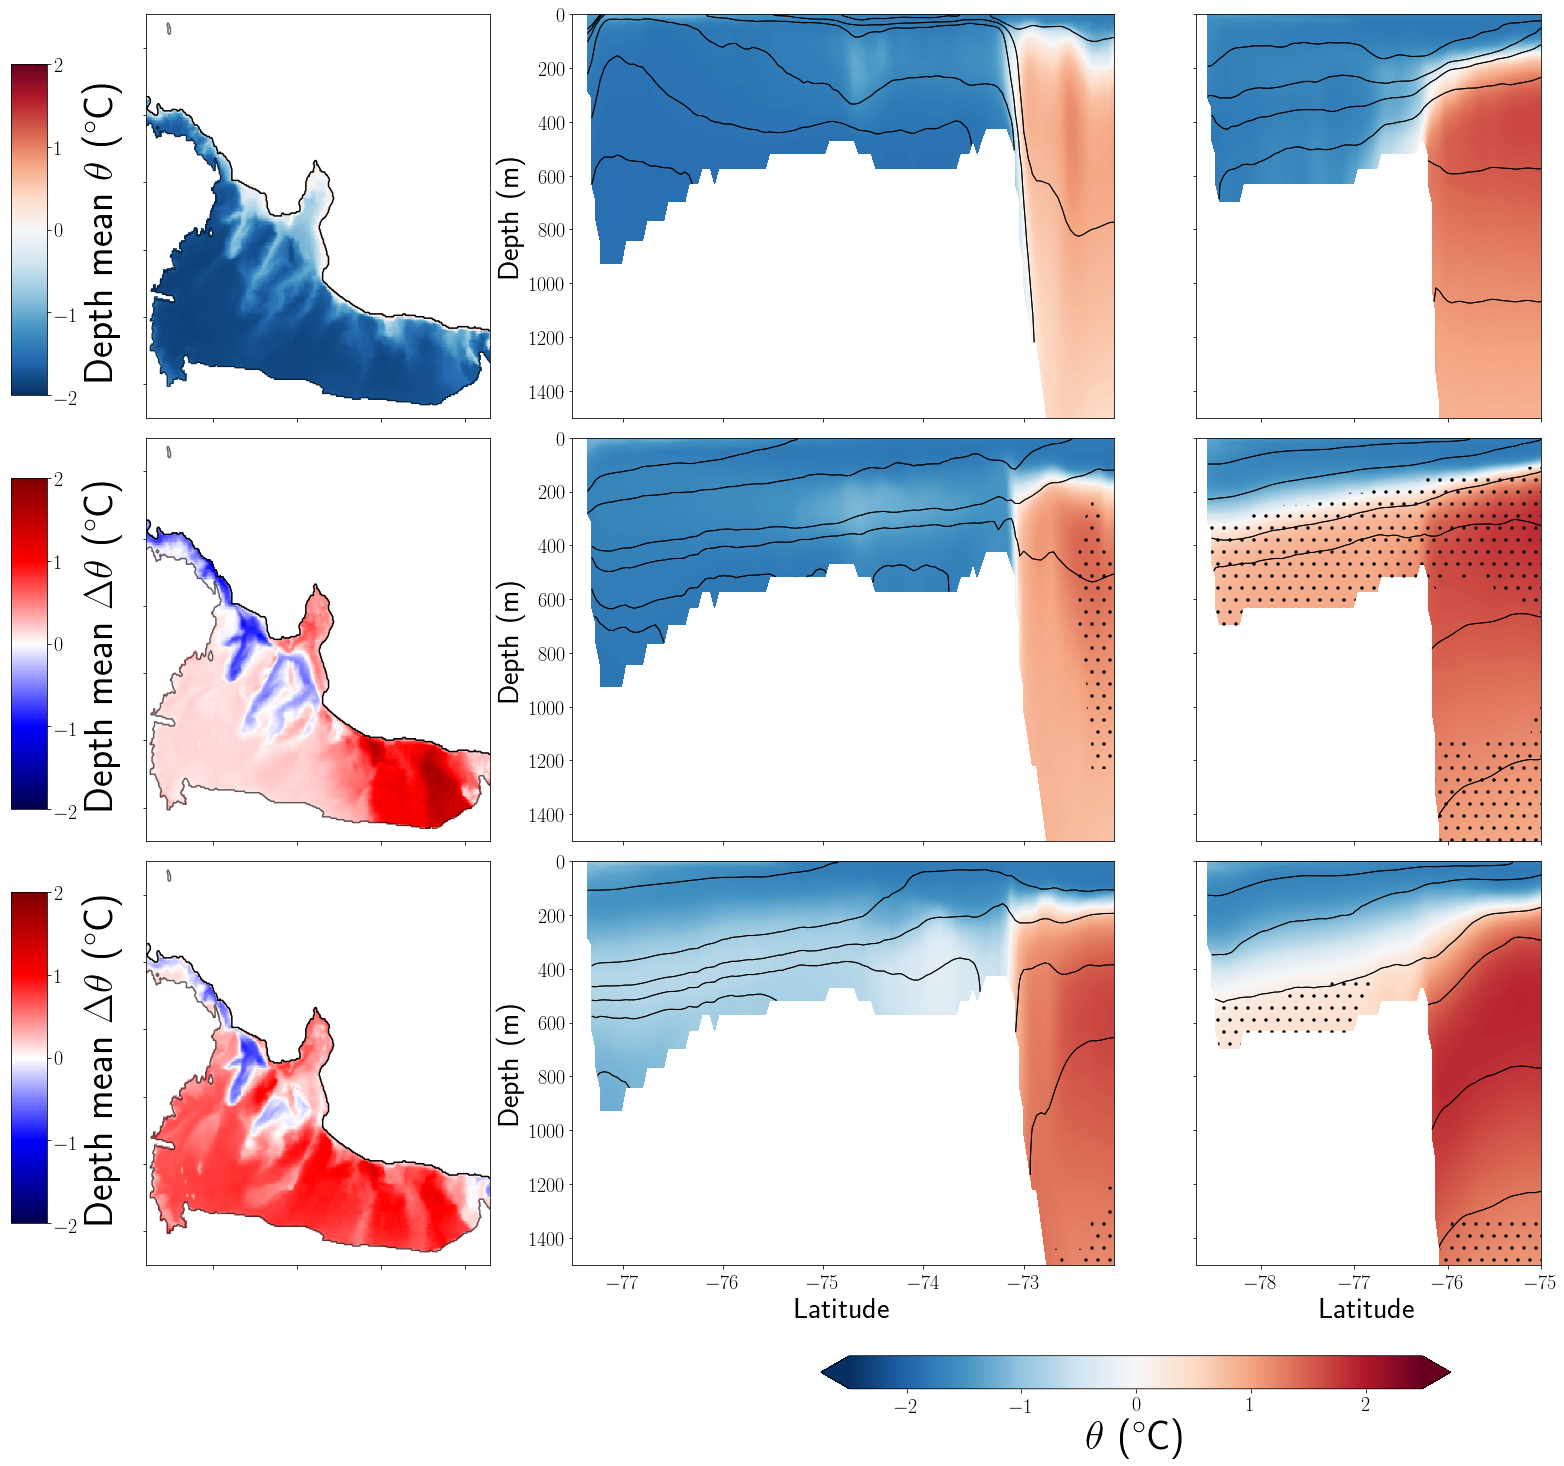

In [36]:
fig=plt.figure(1,(25,23))
gs = gridspec.GridSpec(3, 3, width_ratios = [7,11,7]) 
gs.update(hspace = 0.05)

ax, ax0, ax1 = plt.subplot(gs[0,0]), plt.subplot(gs[1,0]), plt.subplot(gs[2,0])
ax2, ax3,ax4 = plt.subplot(gs[0,2]), plt.subplot(gs[1,2]), plt.subplot(gs[2,2])
ax5,ax6,ax7 = plt.subplot(gs[0,1]), plt.subplot(gs[1,1]), plt.subplot(gs[2,1])
control_temp, anomaly_temp = ross_temp_maps(ax,ax0,ax1)
west_ross_transects(ax5,ax6,ax7)

temp = east_ross_transects(ax2,ax3, ax4)

cax = fig.add_axes([0.5, 0.05, 0.35, 0.02])
cbar=plt.colorbar(temp,cax = cax,orientation='horizontal',shrink = 0.5, ticks = [-3, -2,-1,0,1,2, 3])
cbar.set_label(r'$\theta$ ($^\circ$C)', fontsize = 40)


cax = fig.add_axes([0.05, 0.65, 0.02, 0.2])
cbar=plt.colorbar(control_temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-3, -2,-1,0,1,2, 3])
cbar.set_label(r'Depth mean $\theta$ ($^\circ$C)', fontsize = 40)


cax = fig.add_axes([0.05, 0.4, 0.02, 0.2])
cbar=plt.colorbar(anomaly_temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-3, -2,-1,0,1,2, 3])
cbar.set_label(r'Depth mean $\Delta \theta$ ($^\circ$C)', fontsize = 40)


cax = fig.add_axes([0.05, 0.15, 0.02, 0.2])
cbar=plt.colorbar(anomaly_temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-3, -2,-1,0,1,2, 3])
cbar.set_label(r'Depth mean $\Delta \theta$ ($^\circ$C)', fontsize = 40)

# figurepath = 'Figures/Ross_Summary.png'
# plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format='png',
#                 transparent=False, bbox_inches='tight', pad_inches=0.1,
#                 frameon=None)
plt.show()